# Orbital-Radar demo

This notebook presents the transformation of groundbased and airborne radar observations to spaceborne radar observations with `orbital_radar`.

## Preparation

Several steps are required if you are using this notebook for the first time.

1. Download the observational data and the EarthCARE CPR range weighting function from [here](https://uni-koeln.sciebo.de/s/amrLECxo1Ifretu).

2. Copy the `orbital_radar_config.toml.example` file to any location outside of the `orbital-radar` directory and rename it to `orbital_radar_config.toml` or a similar name.

3. Adjust the following paths in the newly created `orbital_radar_config.toml` file:

    1. Under `[radar]` adjust the `file_earthcare` path by the path to the `CPR_PointTargetResponse.txt` file.

    2. Under `[paths.min]` adjust the `radar`, `cloudnet`, and `output` data paths.

    3. Under `[paths.arm]` adjust the `radar`, and `output` data paths.

    4. Under `[paths.mp5]` adjust the `radar`, and `output` data paths.

    5. TODO: Description for ICON-PAMTRA simulations and observations at Ny-Alesund

4. Set the environment variable `ORBITAL_RADAR_CONFIG_PATH` to the directory of the `orbital_radar_config.toml` file. This can be done with a `.env` file based on the example file `.env.example` in the root directory of `orbital-radar`.

5. (Optional) Adjust satellite radar configuration under [spaceborne_radar] or [spaceborne_radar.radar_specs]

6. (Optional) Adjust general settings under [prepare.general] such as attenuation correction

## Import Packages

We can now import `orbital_radar` and some additional plotting functions for the noise tables and weighting functions.

In [1]:
import orbital_radar as ora
from orbital_radar.plotting.curtains import plot_along_track
from orbital_radar.plotting.noise import plot_noise
from orbital_radar.plotting.weighting import (
    plot_along_track_weighting_function,
    plot_range_weighting_function,
)

In [2]:
# constants
WRITE_OUTPUT = False  # set this to write simulation output
CONFIG_FILE = "orbital_radar_config.toml"  # name of config file

## Groundbased to CPR

The following presents groundbased observations on 14 February 2022 from Mindelo, Cape Verde, during the ESA ASKOS campaign. The attenuation correction in `orbital-radar` is based on [Cloudnet](https://cloudnet.fmi.fi/).

### Case 1: ACTRIS data

#### Simulation

The transformation of groundbased observations to CPR requires some preprocessing such as conversion of range to height and interpolation onto a regular grid. This is done by the `Suborbital` class. To create on instance of this class, we need to provide the geometry (groundbased or airborne), site name, configuration file, radar name, and radar file format. A summary of the parameters is printed upon initialization.

In [3]:
ground = ora.Suborbital(
    geometry="groundbased",
    name="min",
    config_file=CONFIG_FILE,
    suborbital_radar="inoe94",
    input_radar_format="geoms",
)

Site: min


Directory paths:
Input: /net/secaire/nrisse/data/orbital_radar_data/groundbased/min/radar
Output: /net/secaire/nrisse/data/orbital_radar_data/simulations


Groundbased data is prepared with:
Mean wind: 6 m/s
Height min: -2500 m
Height max: 17500 m
Height res: 10 m


Nyquist velocity parameter is used instead of pulse repition frequency.
Satellite: EarthCARE
Frequency: 94.05000000000001 GHz
Velocity: 7600 m s-1
Antenna diameter: 2.5 m
Altitude: 400000 m
Pulse length: 500 m
Horizontal resolution: 500 m
Vertical resolution: 100 m
Nyquist velocity: 5.7 m s-1
Pulse repetition frequency: 7150 Hz



In [4]:
# run the transformation for a specific date
ground.run_date(date="2022-02-14", write_output=WRITE_OUTPUT)

Reading radar file 1/24: /net/secaire/nrisse/data/orbital_radar_data/groundbased/min/radar/2022/02/14/groundbased_radar_profiler_inoe94_ucologne_mindelo_20220214T000000_20220214T005958_001.nc
Reading radar file 2/24: /net/secaire/nrisse/data/orbital_radar_data/groundbased/min/radar/2022/02/14/groundbased_radar_profiler_inoe94_ucologne_mindelo_20220214T010000_20220214T015959_001.nc
Reading radar file 3/24: /net/secaire/nrisse/data/orbital_radar_data/groundbased/min/radar/2022/02/14/groundbased_radar_profiler_inoe94_ucologne_mindelo_20220214T020002_20220214T025957_001.nc
Reading radar file 4/24: /net/secaire/nrisse/data/orbital_radar_data/groundbased/min/radar/2022/02/14/groundbased_radar_profiler_inoe94_ucologne_mindelo_20220214T030000_20220214T035958_001.nc
Reading radar file 5/24: /net/secaire/nrisse/data/orbital_radar_data/groundbased/min/radar/2022/02/14/groundbased_radar_profiler_inoe94_ucologne_mindelo_20220214T040001_20220214T045958_001.nc
Reading radar file 6/24: /net/secaire/nr

/home/nrisse/phd/projects/earthcare_simulator/orbital-radar/src/orbital_radar/readers/radar.py:225: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  self.ds_rad["time"] = self.ds_rad["time"].astype(


Vm sign convention: negative=upward, positive=downward
Quality checks for min radar data.
Reading cloudnet_ecmwf Cloudnet data: /net/secaire/nrisse/data/orbital_radar_data/groundbased/min/cloudnet/2022/02/14/20220214_mindelo_ecmwf.nc
Converting radar range grid to height above mean sea level
Using mean wind for along-track coordinates
Check input dataset
Prepare input dataset
Compute weighting functions
Apply detection limit to input data
Convolve along track
Integrate along track
Convolve height
Apply detection limit on satellite view
Calculate Ze noise
Calculate Vm noise
Fold Vm
Calculate non-uniform beam filling
Calculate non-uniform beam filling flag
Calculate Doppler velocity bias
Calculate Doppler velocity bias flag
Calculate multiple scattering flag
Calculate signal fraction


/home/nrisse/miniconda3/envs/orbital-radar-env/lib/python3.11/site-packages/xarray/core/computation.py:808: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Add attributes


In [5]:
# all transformation results are stored in the ds object
# the time dimension of the input is preserved
ground.ds

<xarray.Dataset>
Dimensions:                     (along_track: 28799, height: 2000, scalar: 1,
                                 along_track_sat: 1036, height_sat: 200)
Coordinates:
  * along_track                 (along_track) float64 0.0 18.0 ... 5.184e+05
  * height                      (height) int64 -2500 -2490 -2480 ... 17480 17490
    time                        (along_track) datetime64[ns] 2022-02-14 ... 2...
  * along_track_sat             (along_track_sat) float64 250.0 ... 5.178e+05
  * height_sat                  (height_sat) int64 -2500 -2400 ... 17300 17400
Dimensions without coordinates: scalar
Data variables: (12/28)
    ze                          (along_track, height) float64 nan nan ... nan
    vm                          (along_track, height) float32 nan nan ... nan
    lon                         (scalar) float32 -24.99
    lat                         (scalar) float32 16.88
    alt                         (scalar) float32 93.0
    ze_acon                     (along_track, height) float64 nan nan ... nan
    ...                          ...
    ms_flag                     (along_track_sat, height_sat) int64 0 0 ... 0 0
    signal_fraction             (along_track_sat, height_sat) float64 0.0 ......
    sat_ifov                    float64 663.2
    sat_range_resolution        int64 100
    sat_along_track_resolution  int64 500
    mean_wind                   int64 6
Attributes: (12/42)
    fill_value:            -999
    program_name:          15km4lev20.05
    PI_NAME:               Antonescu;Bogdan
    PI_AFFILIATION:        National Institute of Research and Development for...
    PI_ADDRESS:            National Institute of Research and Development for...
    PI_MAIL:               bogdan.antonescu@inoe.ro
    ...                    ...
    FILL_VALUE:            -999
    INSTRUMENT_MODEL:      94 GHz dual pol.
    MDF_PROGRAM_USED:      15km4lev20.05
    title:                 EarthCARE simulated from suborbital observations w...
    created:               2024-02-13T16:21:40
    description:           Simulated spaceborne radar reflectivity and Dopple...

#### Visualization

Three visualization routines come with `orbital-radar`:

- `.plot()`: Along track-height curtains
- `.plot_histogram()`: CFAD histograms
- `.plot_scatter()`: Scatter plot between two variables

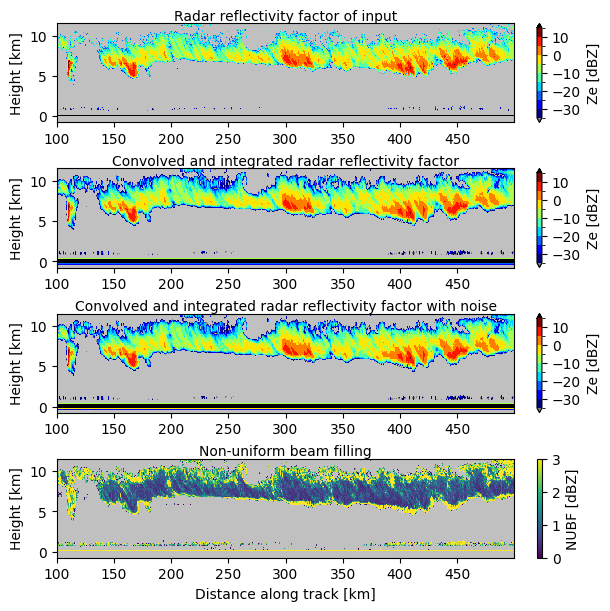

In [6]:
# along track-height curtains of Ze variables and non-uniform beam filling
fig = ground.plot(
    variables=["ze", "ze_sat", "ze_sat_noise", "nubf"],
    figsize=(6, 6),
    a0=1e5,
    a1=5e5,
    h0=-0.75e3,
    h1=11.5e3,
)

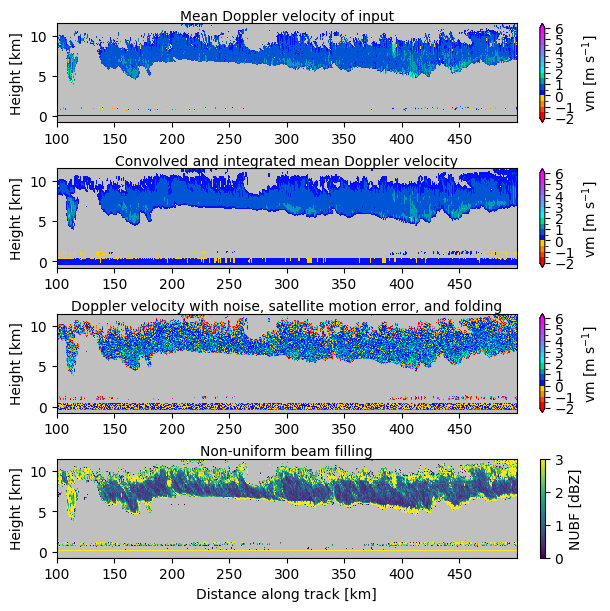

In [7]:
# along track-height curtains of vm variables and non-uniform beam filling
fig = ground.plot(
    variables=["vm", "vm_sat", "vm_sat_folded", "nubf"],
    figsize=(6, 6),
    a0=1e5,
    a1=5e5,
    h0=-0.75e3,
    h1=11.5e3,
)

/home/nrisse/miniconda3/envs/orbital-radar-env/lib/python3.11/site-packages/xarray/core/computation.py:808: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/nrisse/miniconda3/envs/orbital-radar-env/lib/python3.11/site-packages/xarray/core/computation.py:808: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


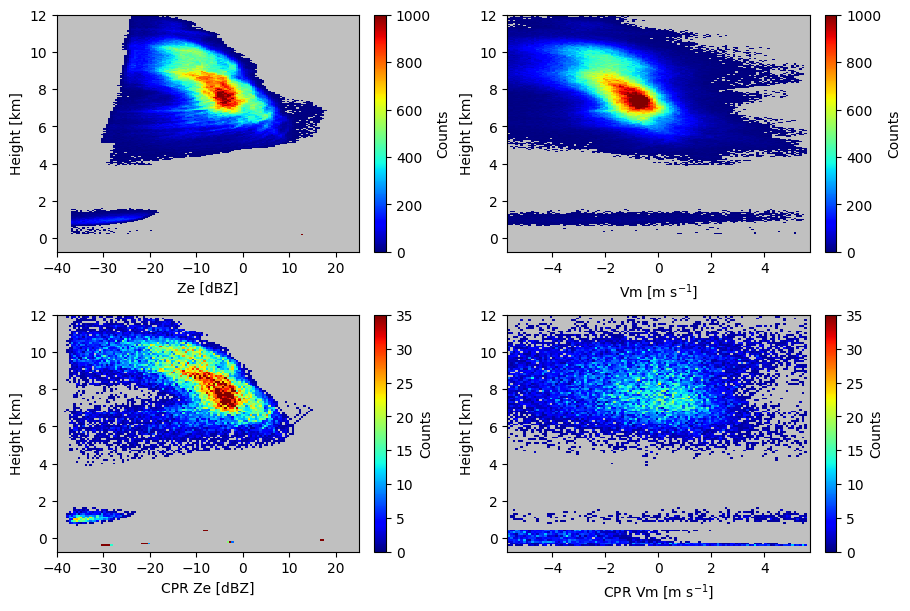

In [8]:
# cfads for groundbased and satellite radar
fig = ground.plot_histogram(
    variables=["ze", "vm", "ze_sat_noise", "vm_sat_folded"],
    vmax=[1000, 1000, 35, 35],
    h=[-0.75, 12],
)

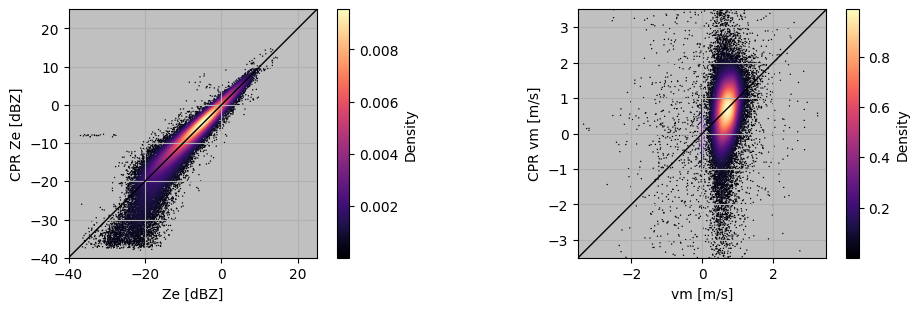

In [9]:
# comparison between groundbased and satellite radar
fig = ground.plot_scatter(var_ze="ze_sat_noise", var_vm="vm_sat_folded")

#### Modifying spaceborne radar configuration

The previous example used the default radar configuration for EarthCARE CPR as selected in the `orbital_radar_config.toml` file. In the following, we will adjust the pulse repition frequency (PRF) of the spaceborne radar. The change of the PRF influences the Doppler velocity resolution of the simulator. Previously, the default Doppler velocity has been used for the simulation. To use a pre-defined PRF, follow these steps: 

1. Copy the `orbital_radar_config.toml` and rename it to `orbital_radar_config_modified_prf.toml`.
2. Add `pulse_repetition_frequency = 7300` under `[spaceborne_radar.radar_specs]`.
3. Change `nyquist_from_prf = true` under `[spaceborne_radar]`.
4. Run the simulation with the new config file

Any configuration setting provided under `radar_specs` will overwrite the default configuration. Through this, you can also provide an entirely new configuration and leave the satellite name parameter `sat_name` empty.

In [10]:
CONFIG_FILE_PRF = "orbital_radar_config_modified_prf.toml"  # name of config file

ground_prf = ora.Suborbital(
    geometry="groundbased",
    name="min",
    config_file=CONFIG_FILE_PRF,
    suborbital_radar="inoe94",
    input_radar_format="geoms",
)

Site: min


Directory paths:
Input: /net/secaire/nrisse/data/orbital_radar_data/groundbased/min/radar
Output: /net/secaire/nrisse/data/orbital_radar_data/simulations


Groundbased data is prepared with:
Mean wind: 6 m/s
Height min: -2500 m
Height max: 17500 m
Height res: 10 m


Nyquist velocity is calculated from pulse repetition frequency.
Satellite: EarthCARE
Frequency: 94.05000000000001 GHz
Velocity: 7600 m s-1
Antenna diameter: 2.5 m
Altitude: 400000 m
Pulse length: 500 m
Horizontal resolution: 500 m
Vertical resolution: 100 m
Nyquist velocity: 5.82 m s-1
Pulse repetition frequency: 7300 Hz



In [11]:
# run the transformation for a specific date
ground_prf.run_date(date="2022-02-14", write_output=WRITE_OUTPUT)

Reading radar file 1/24: /net/secaire/nrisse/data/orbital_radar_data/groundbased/min/radar/2022/02/14/groundbased_radar_profiler_inoe94_ucologne_mindelo_20220214T000000_20220214T005958_001.nc
Reading radar file 2/24: /net/secaire/nrisse/data/orbital_radar_data/groundbased/min/radar/2022/02/14/groundbased_radar_profiler_inoe94_ucologne_mindelo_20220214T010000_20220214T015959_001.nc
Reading radar file 3/24: /net/secaire/nrisse/data/orbital_radar_data/groundbased/min/radar/2022/02/14/groundbased_radar_profiler_inoe94_ucologne_mindelo_20220214T020002_20220214T025957_001.nc
Reading radar file 4/24: /net/secaire/nrisse/data/orbital_radar_data/groundbased/min/radar/2022/02/14/groundbased_radar_profiler_inoe94_ucologne_mindelo_20220214T030000_20220214T035958_001.nc
Reading radar file 5/24: /net/secaire/nrisse/data/orbital_radar_data/groundbased/min/radar/2022/02/14/groundbased_radar_profiler_inoe94_ucologne_mindelo_20220214T040001_20220214T045958_001.nc
Reading radar file 6/24: /net/secaire/nr

/home/nrisse/phd/projects/earthcare_simulator/orbital-radar/src/orbital_radar/readers/radar.py:225: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  self.ds_rad["time"] = self.ds_rad["time"].astype(


Vm sign convention: negative=upward, positive=downward
Quality checks for min radar data.
Reading cloudnet_ecmwf Cloudnet data: /net/secaire/nrisse/data/orbital_radar_data/groundbased/min/cloudnet/2022/02/14/20220214_mindelo_ecmwf.nc
Converting radar range grid to height above mean sea level
Using mean wind for along-track coordinates
Check input dataset
Prepare input dataset
Compute weighting functions
Apply detection limit to input data
Convolve along track
Integrate along track
Convolve height
Apply detection limit on satellite view
Calculate Ze noise
Calculate Vm noise
Fold Vm
Calculate non-uniform beam filling
Calculate non-uniform beam filling flag
Calculate Doppler velocity bias
Calculate Doppler velocity bias flag
Calculate multiple scattering flag
Calculate signal fraction


/home/nrisse/miniconda3/envs/orbital-radar-env/lib/python3.11/site-packages/xarray/core/computation.py:808: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Add attributes


### Case 2: ARM data

Next, we present a low cloud case with open and closed cell formations analyzed in [Rémillard and Tselioudis (2015)](https://doi.org/10.1175/JCLI-D-15-0066.1). We use radar observations from 13 and 22 November 2009 shown in Fig. 10.

#### Simulation

In [12]:
ground_arm = ora.Suborbital(
    geometry="groundbased",
    name="arm",
    config_file=CONFIG_FILE,
    suborbital_radar="arm",
    input_radar_format="arm",
)

Site: arm


Directory paths:
Input: /net/secaire/nrisse/data/orbital_radar_data/groundbased/arm/radar
Output: /net/secaire/nrisse/data/orbital_radar_data/simulations


Groundbased data is prepared with:
Mean wind: 6 m/s
Height min: -2500 m
Height max: 17500 m
Height res: 10 m


Nyquist velocity parameter is used instead of pulse repition frequency.
Satellite: EarthCARE
Frequency: 94.05000000000001 GHz
Velocity: 7600 m s-1
Antenna diameter: 2.5 m
Altitude: 400000 m
Pulse length: 500 m
Horizontal resolution: 500 m
Vertical resolution: 100 m
Nyquist velocity: 5.7 m s-1
Pulse repetition frequency: 7150 Hz



In [13]:
ground_arm.run_date(date="2009-11-13", write_output=WRITE_OUTPUT)
ds1 = ground_arm.ds

ground_arm.run_date(date="2009-11-22", write_output=WRITE_OUTPUT)
ds2 = ground_arm.ds

Reading radar file 1/1: /net/secaire/nrisse/data/orbital_radar_data/groundbased/arm/radar/grwarsclwacr1kolliasM1.c1.20091113.000000.cdf
Vm sign convention: negative=upward, positive=downward
Quality checks for arm radar data.
Assume that input radar grid is defined as height above mean sea level
Using mean wind for along-track coordinates
Check input dataset
Prepare input dataset
Compute weighting functions
Apply detection limit to input data
Convolve along track
Integrate along track
Convolve height
Apply detection limit on satellite view
Calculate Ze noise
Calculate Vm noise
Fold Vm
Calculate non-uniform beam filling
Calculate non-uniform beam filling flag
Calculate Doppler velocity bias
Calculate Doppler velocity bias flag
Calculate multiple scattering flag
Calculate signal fraction


/home/nrisse/miniconda3/envs/orbital-radar-env/lib/python3.11/site-packages/xarray/core/computation.py:808: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Add attributes
Reading radar file 1/1: /net/secaire/nrisse/data/orbital_radar_data/groundbased/arm/radar/grwarsclwacr1kolliasM1.c1.20091122.000000.cdf
Vm sign convention: negative=upward, positive=downward
Quality checks for arm radar data.
Assume that input radar grid is defined as height above mean sea level
Using mean wind for along-track coordinates
Check input dataset
Prepare input dataset
Compute weighting functions
Apply detection limit to input data
Convolve along track
Integrate along track
Convolve height
Apply detection limit on satellite view
Calculate Ze noise
Calculate Vm noise
Fold Vm
Calculate non-uniform beam filling
Calculate non-uniform beam filling flag
Calculate Doppler velocity bias
Calculate Doppler velocity bias flag
Calculate multiple scattering flag
Calculate signal fraction


/home/nrisse/miniconda3/envs/orbital-radar-env/lib/python3.11/site-packages/xarray/core/computation.py:808: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Add attributes


#### Visualization

Now, we visualize the along track-height curtains. The time windoe from 10 to 17 UTC is chosen to be equivalent with [Fig. 10](https://journals.ametsoc.org/view/journals/clim/28/24/full-jcli-d-15-0066.1-f10.jpg) in [Rémillard and Tselioudis (2015)](https://doi.org/10.1175/JCLI-D-15-0066.1).

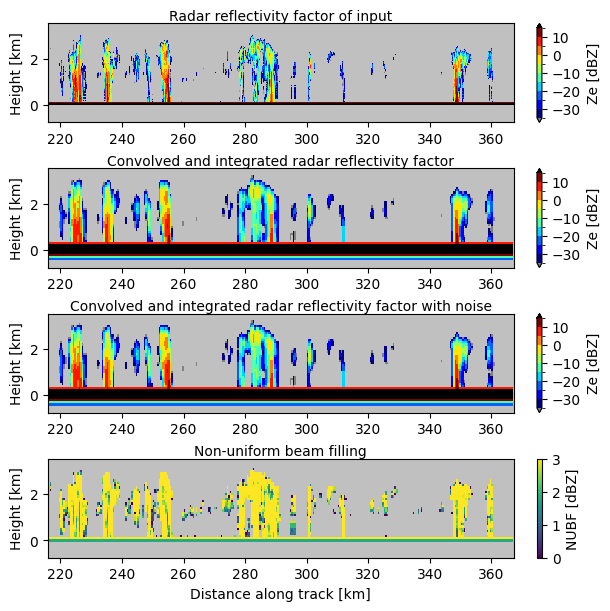

In [14]:
# along track-height curtains of Ze variables and non-uniform beam filling
hour_start = 10
hour_end = 17

fig = plot_along_track(
    ds1,
    variables=["ze", "ze_sat", "ze_sat_noise", "nubf"],
    figsize=(6, 6),
    a0=hour_start * 3600 * ground_arm.prepare["mean_wind"],
    a1=hour_end * 3600 * ground_arm.prepare["mean_wind"],
    h0=-0.75e3,
    h1=3.5e3,
)

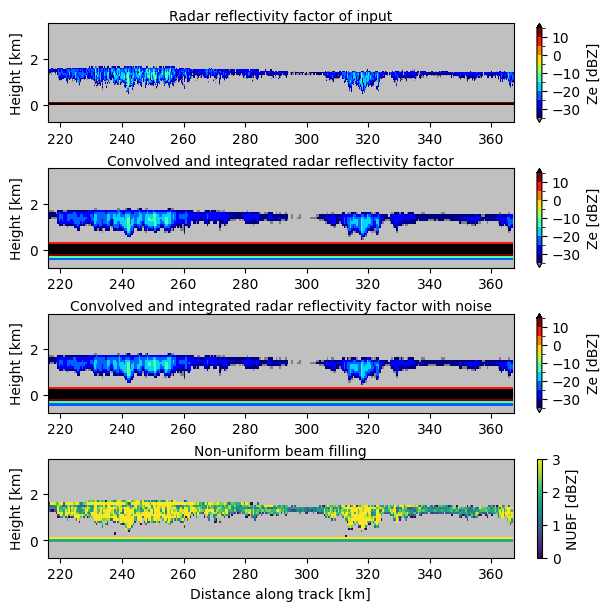

In [15]:
# along track-height curtains of Ze variables and non-uniform beam filling
hour_start = 10
hour_end = 17

fig = plot_along_track(
    ds2,
    variables=["ze", "ze_sat", "ze_sat_noise", "nubf"],
    figsize=(6, 6),
    a0=hour_start * 3600 * ground_arm.prepare["mean_wind"],
    a1=hour_end * 3600 * ground_arm.prepare["mean_wind"],
    h0=-0.75e3,
    h1=3.5e3,
)

## Airborne to CPR

The following presents airborne observations on 1 April 2019 in the Fram Strait during the AFLUX campaign. This case is also presented in [Schirmacher et al. (2023)](https://doi.org/10.5194/amt-16-4081-2023).

### Simulation

Airborne simulations work in a similar way as the groundbased simulation. Only the geometry needs to be set to `airborne`. Further, we specify the `mp5` configuration, the MiRAC radar name, and the radar input format.

In [16]:
airborne = ora.Suborbital(
    geometry="airborne",
    name="mp5",
    config_file=CONFIG_FILE,
    suborbital_radar="mirac",
    input_radar_format="mirac_p5",
)

Site: mp5


Directory paths:
Input: /net/secaire/nrisse/data/orbital_radar_data/airborne/mp5/radar
Output: /net/secaire/nrisse/data/orbital_radar_data/simulations


Airborne data is prepared with:
Mean flight velocity: 60 m/s
Height min: -2500 m
Height max: 17500 m
Height res: 10 m


Nyquist velocity parameter is used instead of pulse repition frequency.
Satellite: EarthCARE
Frequency: 94.05000000000001 GHz
Velocity: 7600 m s-1
Antenna diameter: 2.5 m
Altitude: 400000 m
Pulse length: 500 m
Horizontal resolution: 500 m
Vertical resolution: 100 m
Nyquist velocity: 5.7 m s-1
Pulse repetition frequency: 7150 Hz



In [17]:
airborne.run_date(date="2019-04-01", write_output=WRITE_OUTPUT)

Reading radar file 1/1: /net/secaire/nrisse/data/orbital_radar_data/airborne/mp5/radar/2019/04/01/mirac_a_AFLUX_polar5_20190401_RF09_hl03.nc
Vm sign convention: negative=upward, positive=downward
Quality checks for mp5 radar data.
Assume that input radar grid is defined as height above mean sea level
Using mean flight velocity for along-track coordinates
Check input dataset
Prepare input dataset
Compute weighting functions
Apply detection limit to input data
Convolve along track


/home/nrisse/phd/projects/earthcare_simulator/orbital-radar/src/orbital_radar/readers/radar.py:225: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  self.ds_rad["time"] = self.ds_rad["time"].astype(


Integrate along track
Convolve height
Apply detection limit on satellite view
Calculate Ze noise
Calculate Vm noise
Fold Vm
Calculate non-uniform beam filling
Calculate non-uniform beam filling flag
Calculate Doppler velocity bias
Calculate Doppler velocity bias flag
Calculate multiple scattering flag
Calculate signal fraction
Add attributes


/home/nrisse/miniconda3/envs/orbital-radar-env/lib/python3.11/site-packages/xarray/core/computation.py:808: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


### Visualization

The visualized segment is similar to the case 3 in [Fig. 4](https://amt.copernicus.org/articles/16/4081/2023/amt-16-4081-2023-f04-web.png) in [Schirmacher et al. (2023)](https://doi.org/10.5194/amt-16-4081-2023).

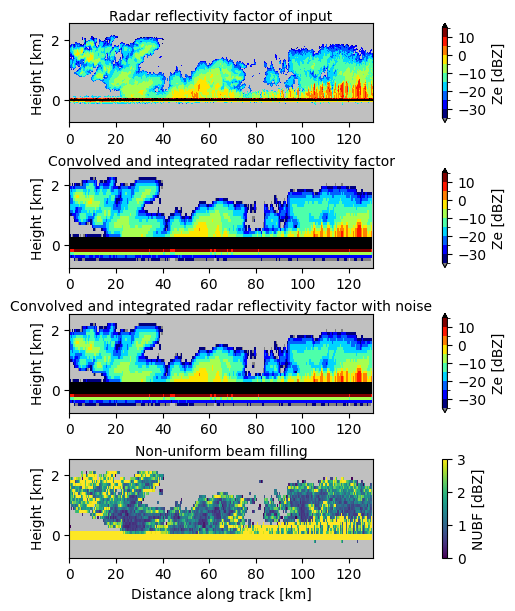

In [18]:
fig = airborne.plot(
    variables=["ze", "ze_sat", "ze_sat_noise", "nubf"],
    figsize=(5, 6),
    h0=-0.75e3,
    h1=2.5e3,
)

/home/nrisse/miniconda3/envs/orbital-radar-env/lib/python3.11/site-packages/xarray/core/computation.py:808: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/nrisse/miniconda3/envs/orbital-radar-env/lib/python3.11/site-packages/xarray/core/computation.py:808: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


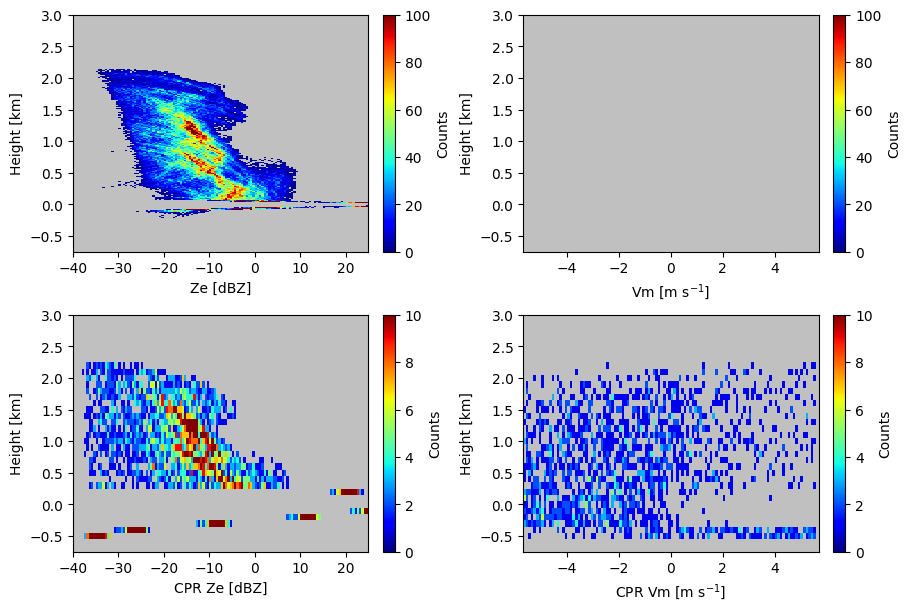

In [19]:
fig = airborne.plot_histogram(
    variables=["ze", "vm", "ze_sat_noise", "vm_sat_noise"],
    vmax=[100, 100, 10, 10],
    h=[-0.75, 3],
)

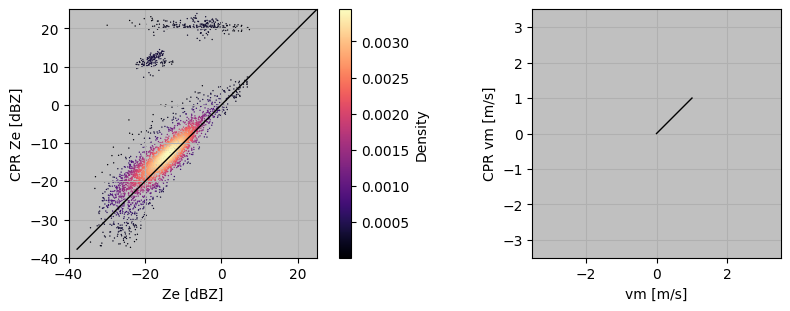

In [20]:
fig = airborne.plot_scatter(var_ze="ze_sat_noise", var_vm="vm_sat_folded")

## Appendix

The appendix shows additional figures for the airborne setup.

### CPR Weighting Functions

#### Range weighting function

We can visualize the range weighting function.

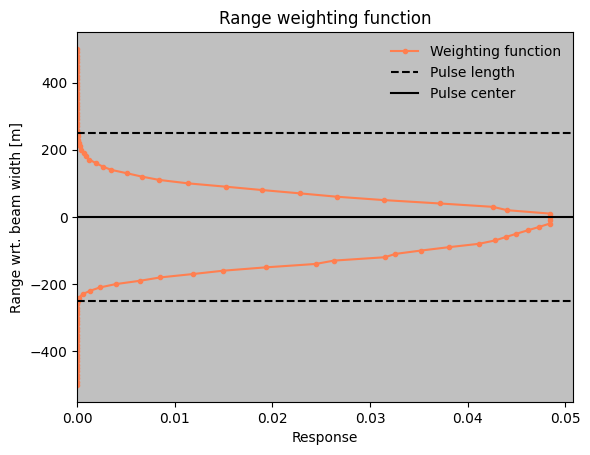

In [21]:
fig = plot_range_weighting_function(airborne)

#### Along-track weighting function

Also, we can visualize the along-track weighting function.

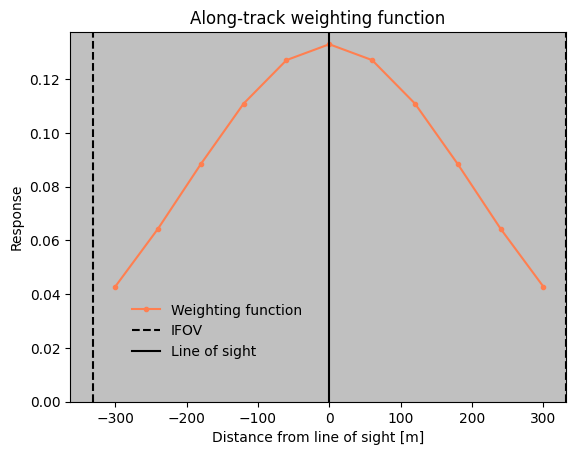

In [22]:
fig = plot_along_track_weighting_function(airborne)

### Noise lookup tables

Finally, these graphs show the radar reflectivity and Doppler velocity uncertainty as a function of radar reflectivity.

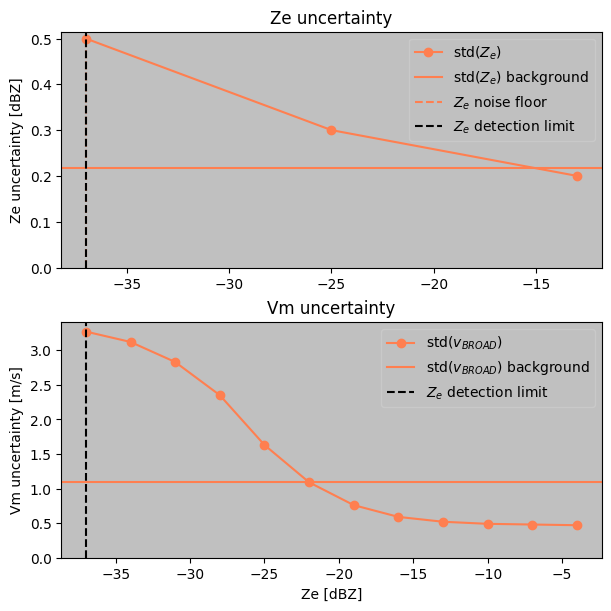

In [23]:
fig = plot_noise(airborne)